# PAC Methods Comparisons

#### Written by: David C.C. Lu

This notebook consists of analysis of different PAC computation methods described in detail [here](Notes_PAC_Method.ipynb).
This is a simple comparisons between PAC methods. i.e., Height Ratios (HR) vs Mean Vector Length (MVL) vs Modulation Index (MI).

For more information on PAC, read the documents in [references](#references), also read the following notebooks:
* [Notes on PAC generator](Notes_PAC_Generator.ipynb): This notebook describes how PAC signals are generated in the analysis performed here.
* [Notes on PAC methods](Notes_PAC_Method.ipynb): This notebook described in detail how each PAC computation method are formulated.

# Overview

This notebook focuses on comparing the performance between different PAC methods.
In order to properly set up the comparison, a number of PAC signals are generated.
The generated signals are based on the modulating PAC (`sig['pac_mod']`) mentioned in the [Notes on PAC generator](Notes_PAC_Generator.ipynb).

The first comparison is on the how well each algorithm performs on tracking the quantified PAC. 
The next comparison is on the performance of the comodulogram computing from each method.

* [Generate a Test Signal](#gen_test_signal)
* [PAC Comodulogram Processing](#comod_procs)
* [Plot Comparison Results](#plot_results)
* [References](#references)

In [1]:
# Import all system modules
import os
import sys
import time

# Import all scientific modules
import numpy as np
from pytf import FilterBank
import mne
from mspacman.generator import noise
from mspacman import PhaseAmplitudeCoupling

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

<a id=gen_test_signal></a>
# Generate a Test Signal

Review this [notebook on PAC generator](Notes_PAC_Generator.ipynb) to understand how signals are generated, and how the data are bundled into `'pacgen_raw.fif'`.

Quick summary of the bundled data, the indices are referred to `case` in the code below:
* 0: Varying the intensity of PAC, pac_mod
* 1: Varying the side band frequencies of the AM signal, frq_mod
* 2: Varying the phase of the AM signal, pha_mod
* 3: Varying the center frequency of the AM signal, frq_var

Each case consists of 10 channels.

We chose case 0 as default. 

In [2]:
fname = os.path.join(os.getcwd(), 'data', 'pacgen_raw.fif')

raw = mne.io.read_raw_fif(fname, preload=True)

dat = raw.get_data()
Nch, Nsamp = dat.shape
fs = int(raw.info['sfreq'])

white = noise.white(Nsamp)
pink = noise.pink(Nsamp)

x = raw.get_data()

x_obj = np.zeros((4,), dtype=np.object)
for i in range(4):
    x_obj[i] = x[11*i:11*(i+1), :]
    
# Select a signal
case = 0
ch = 10

# Select signal to compute PAC on
x_ = x_obj[case].copy()
xn_ = x_obj[case].copy()

xn_ += white
xn_ += pink

Opening raw data file /Users/davidlu/Developer/PhD Projects/notes_mspacman/data/pacgen_raw.fif...
Isotrak not found
    Range : 0 ... 131071 =      0.000 ...     8.000 secs
Ready.
Reading 0 ... 131071  =      0.000 ...     8.000 secs...


<a id=comod_procs></a>
# PAC Comodulogram Processing

The generated signals are filtered according to the parameters set.
Since case 0 was chosen as default, the filter bank parameters are set to accomodate such frequency ranges.

In [3]:
# Set Parameters
dp = 3
da = 30
fpsize = 15
fasize = 15

p_range = (6, 50)
a_range = (60, 500)

fp = np.arange(*p_range, int(np.ceil(np.diff(p_range)/fpsize)), dtype=int)
fa = np.arange(*a_range, int(np.ceil(np.diff(a_range)/fasize)), dtype=int)

fois_lo = np.asarray([(p-dp, p+dp) for p in fp])
fois_hi = np.asarray([(a-da, a+da) for a in fa])

In [4]:
# Processing Comodulogram
nch, nsamp = xn_.shape
mi2 = PhaseAmplitudeCoupling(nch=11, nsamp=nsamp, freq_phase=fois_lo, freq_amp=fois_hi, sample_rate=fs,\
                             nprocs=3, pac='mi', nbins=10, mprocs=True)

hr2 = PhaseAmplitudeCoupling(nch=11, nsamp=nsamp, freq_phase=fois_lo, freq_amp=fois_hi, sample_rate=fs, \
                             nprocs=3, pac='hr', nbins=10, mprocs=True)

mvl2 = PhaseAmplitudeCoupling(nch=11, nsamp=nsamp, freq_phase=fois_lo, freq_amp=fois_hi, sample_rate=fs, \
                              nprocs=3, pac='mvl', mprocs=True)

pmi2 = mi2.comodulogram(xn_)[ch,:,:]
mi2.kill()

phr2 = hr2.comodulogram(xn_)[ch,:,:]
hr2.kill()

pmvl2 = mvl2.comodulogram(xn_, normalize=True)[ch,:,:]
mvl2.kill()

INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank

In [5]:
# Processing Single PAC
mi = PhaseAmplitudeCoupling(nch=11, nsamp=nsamp, freq_phase=np.asarray([(14, 30)]), freq_amp=np.asarray([(80, 200)]), \
                            sample_rate=fs, nprocs=1, pac='mi', nbins=10)
mi_sim1 = mi.comodulogram(x_)[:,0,0]
mi_simn1 = mi.comodulogram(xn_)[:,0,0]

hr = PhaseAmplitudeCoupling(nch=11, nsamp=nsamp, freq_phase=np.asarray([(14, 30)]), freq_amp=np.asarray([(80, 200)]), \
                            sample_rate=fs, nprocs=1, pac='hr', nbins=10)
hr_sim1 = hr.comodulogram(x_)[:,0,0]
hr_simn1 = hr.comodulogram(xn_)[:,0,0]

mvl = PhaseAmplitudeCoupling(nch=11, nsamp=nsamp, freq_phase=np.asarray([(14, 30)]), freq_amp=np.asarray([(80, 200)]), \
                             sample_rate=fs, nprocs=1, pac='mvl')
mvl_sim1 = mvl.comodulogram(x_, normalize=True)[:,0,0]
mvl_simn1 = mvl.comodulogram(xn_, normalize=True)[:,0,0]

mi.kill()
hr.kill()
mvl.kill()

INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
/Users/davidlu/.virtualenvs/py-phd/lib/python3.6/site-packages/mspacman-0.1-py3.6.egg/mspacman/utilities/parallel.py:35: UserWarning: The multiprocessing is disabled! To enable multiprocessing, specify 'ins_shape' and 'out_shape' for preallocating shared memory.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
INFO:<class 'pytf.filter.filterbank.Filte

<a id=plot_results></a>
# Plot Comparison Results

Text(-5,15,'B')

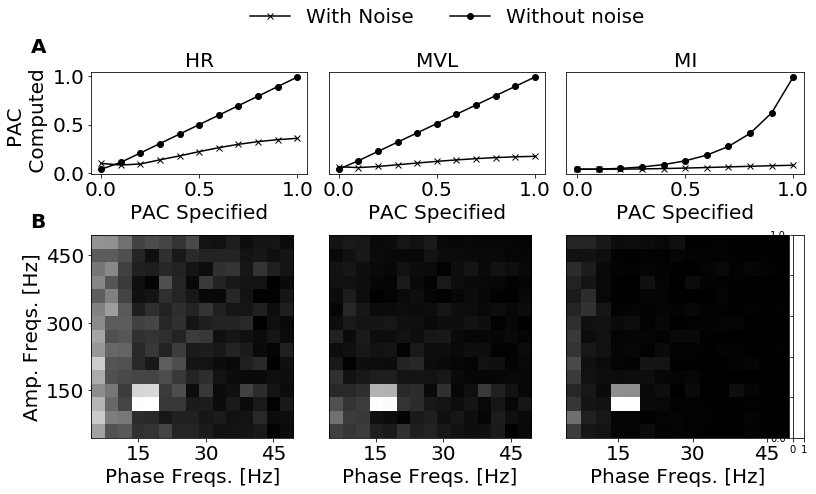

In [6]:
fontsize = dict(
    axis_label  = 20,
    title_label = 20,
    tick_label  = 20,
    fign_label  = 20
)

pacs_specified = np.linspace(0,1,11)
pac_outs = ['HR', 'MVL', 'MI']
#################################
# Create the plots of fig_pacio
#################################
fig_result1 = plt.figure(figsize=(12,7))
gs1_result1 = GridSpec(2, 1, height_ratios=[1,2])
gs2_result1 = GridSpec(2, 1, height_ratios=[1,2])
gs3_result1 = GridSpec(2, 1, height_ratios=[1,2])

gs1_result1.update(left=.1, right=.1+.25, top=.85, hspace=.4, wspace=2.5)
gs2_result1.update(left=.375, right=.375+.25, top=.85, hspace=.4, wspace=2.5)
gs3_result1.update(left=.375+.25+.025, right=.375+.5+.05, top=.85, hspace=.4, wspace=2.5)

axa1_result1 = [0, 1, 2]
axb1_result1 = [0, 1, 2]
axa1_result1[0] = plt.subplot(gs1_result1[0, 0])
axb1_result1[0] = plt.subplot(gs1_result1[1, 0])

axa1_result1[1] = plt.subplot(gs2_result1[0, 0])
axb1_result1[1] = plt.subplot(gs2_result1[1, 0])

axa1_result1[2] = plt.subplot(gs3_result1[0, 0])
axb1_result1[2] = plt.subplot(gs3_result1[1, 0])

l1, l2 = axa1_result1[0].plot(pacs_specified, hr_sim1, 'k-o', pacs_specified, hr_simn1, 'k-x')
l3, l4 = axa1_result1[1].plot(pacs_specified, mvl_sim1, 'k-o', pacs_specified, mvl_simn1, 'k-x')
l5, l6 = axa1_result1[2].plot(pacs_specified, mi_sim1, 'k-o', pacs_specified, mi_simn1, 'k-x')

# Plot organization properties
fig_result1.legend((l1, l2), ('Without noise', 'With Noise'), loc=9, ncol=3, bbox_to_anchor=(0.5, 1),
                   fontsize=fontsize['tick_label'], mode='expand', frameon=False)

axa1_result1[0].set_ylabel('PAC \n Computed', fontsize=fontsize['axis_label'])
axa1_result1[0].set_yticks([0, 0.5, 1])
axa1_result1[1].set_yticks([])
axa1_result1[2].set_yticks([])

[ax.set_xlabel('PAC Specified', fontsize=fontsize['axis_label']) for (col,),ax in np.ndenumerate(axa1_result1)]
[ax.set_title(pac_outs[col], fontsize=fontsize['title_label']) for (col,),ax in np.ndenumerate(axa1_result1)]

for ax in axa1_result1:
    ax.set_xticks([0, 0.5, 1])

for (col,), ax in np.ndenumerate(axa1_result1):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize['tick_label'])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize['tick_label'])

#################################
# Create the plots of fig_comod
#################################

vpacmin = np.min([phr2[:,:].min(), pmvl2[:,:].min(), pmi2[:,:].min()])
vpacmax = np.max([phr2[:,:].max(), pmvl2[:,:].max(), pmi2[:,:].max()])

hr2.plot_comodulogram(ch=ch, axs=[axb1_result1[0]], cbar=False, cmap='gray')
mvl2.plot_comodulogram(ch=ch, axs=[axb1_result1[1]], cbar=False, cmap='gray')
mi2.plot_comodulogram(ch=ch, axs=[axb1_result1[2]], cbar=False, cmap='gray')

# Plot organization properties
axb1_result1[0].set_ylabel('Amp. Freqs. [Hz]', fontsize=fontsize['axis_label'])
[ax.set_xlabel('Phase Freqs. [Hz]', fontsize=fontsize['axis_label']) for ax in axb1_result1]
for ax in axb1_result1:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize['tick_label'])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize['tick_label'])

[ax.set_yticks([]) for ax in axb1_result1[1:]]
axb1_result1[0].set_yticks([3, 8, 13])
axb1_result1[0].set_yticklabels(['150', '300', '450'], fontsize=fontsize['title_label'])
axb1_result1[0].set_xticks([3, 8, 13])
axb1_result1[0].set_xticklabels(['15', '30', '45'], fontsize=fontsize['title_label'])

axb1_result1[1].set_xticks([3, 8, 13])
axb1_result1[1].set_xticklabels(['15', '30', '45'], fontsize=fontsize['title_label'])

axb1_result1[2].set_xticks([3, 8, 13])
axb1_result1[2].set_xticklabels(['15', '30', '45'], fontsize=fontsize['title_label'])




divider = [make_axes_locatable(ax) for ax in axb1_result1]
cax2 = [div.append_axes("right", size="5%", pad=0.05) for div in divider]
fig_result1.delaxes(fig_result1.axes[6])
fig_result1.delaxes(fig_result1.axes[6])

#Create second colorbar
# cbar2 = fig_result1.colorbar(mi2.cax[-1], cax = cax2[-1])
# cbar2.ax.tick_params(labelsize=fontsize['tick_label']) 

axb1_result1[0].text(-5, 28, 'A', fontsize=fontsize['title_label'], weight='bold')
axb1_result1[0].text(-5, 15, 'B', fontsize=fontsize['title_label'], weight='bold')

We demonstrated that all three PAC computing methods are capable of not only detecting PAC, but they are also able to track the changes in PAC intensities. It can be seen that MVL demonstrated the best performance out of the three given a simulated signal. HR showed difficulty in localizing a frequency pair (the comodulogram is the noisiest of three). MI showed nonlinearity in changes of PAC strength with the absent of signal noise. 

In [7]:
save_plot = False
#################################
# Save both figures
#################################
path_to_save_pacio = os.path.realpath(os.path.join(os.getcwd(),'pac_result1.eps'))

if save_plot:
    fig_result1.savefig(path_to_save_pacio)

<a id=references></a>
# References

<a id=ref1></a>
[1] A. B. L. Tort et al., “Measuring phase-amplitude coupling between neuronal oscillations of different frequencies,” J. Neurophysiol., vol. 104, no. 2, pp. 1195–1210, 2010. Available: http://jn.physiology.org/content/104/2/1195.

<a id=ref2></a>
[2] Brain Storm, "Phase-Amplitude Coupling." http://neuroimage.usc.edu/brainstorm/Tutorials/TutPac.

<a id=ref3></a>
[3] B. Pittman-Polletta, W.-H. Hsieh, S. Kaur, M.-T. Lo, and K. Hu, “Detecting phase-amplitude coupling with high frequency resolution using adaptive decompositions,” J. Neurosci. Methods, vol. 226, pp. 15–32, 2014. Available: http://www.sciencedirect.com/science/article/pii/S016502701400017X?via%3Dihub